# The first prototype of the sensitivity analysis workflow. 

The workflow is designed to run from the inside of the docker container and assumes a specific folder layout.  

Authors: Tobey Carman and Elchin Jafarov

## Working with the docker 
Assuming that docker was successfully installed, navigate to your local dvmdostem folder:

1. Strat the containers <br/>
`$ docker compose up -d` <br/>
2. Enter to the container <br/>
`$ docker compose exec dvmdostem-run bash` <br/>
3. Start jupyter notebook inside the /work folder <br/>
`$ jupyter notebook --ip 0.0.0.0 --no-browser --allow-root` <br/>
4. Copy the url into your browser. <br/>
5. When done. Shut down container <br/>
`$ docker compose down` <br/>

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import output_utils as ou
import param_util as pu
import os
import subprocess

import Sensitivity


In [2]:
param_specs = [
    {'name':'cmax', 'cmtnum':4, 'pftnum':3, 'bounds':[100,700],'enabled':True },
    {'name':'rhq10', 'cmtnum':4, 'pftnum':None, 'bounds':[0.1,5],'enabled':True },
    {'name':'micbnup', 'cmtnum':4, 'pftnum':None, 'bounds':[0.1,10],'enabled':True },
]

In [3]:
def generate_sample_matrix(pspecs, N, method='uniform'):
    
    if not method == 'uniform':
        raise RuntimeError("Not implemented yet!")
    
    sample_matrix = {}
    for i, p in enumerate(filter(lambda x: x['enabled'], param_specs)):
        samples = np.linspace(p['bounds'][0], p['bounds'][1], N)
        sample_matrix[p['name']] = samples
    return pd.DataFrame(sample_matrix)

In [4]:
'{:04d}'.format(1)


'0001'

In [5]:
sample_matrix = generate_sample_matrix(param_specs, 10)
# print(sample_matrix)
# len(sample_matrix)
# for i, row in enumerate(sample_matrix):
#     print(i, row)
    
# print()
# for row in sample_matrix.iterrows():
#     print(row)

In [6]:
x2 = Sensitivity.SensitivityDriver(param_specs, sample_matrix)

In [7]:
x2.params
x2.setup_multi()

[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/workflows/sensitivity_analysis/sample_000000000

[SA:setup] /work/scripts/runmask-util.py --reset --yx 0 0 /data/workflows/sensitivity_analysis/sample_000000000/run-mask.nc

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000000/config/output_spec.csv --on GPP m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000000/config/output_spec.csv --on VEGC m p

[SA:setup] /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/sample_000000000/config/output_spec.csv --on CMTNUM y

CONFIG_FILE: /data/workflows/sensitivity_analysis/sample_000000000/config/config.js was modified!

[SA:setup] /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/workflows/sensitivity_anal

In [9]:
# Sets initial values from the parameters directory - works better when used with 
# Sensitivity.setup_single()  
for param in param_specs:
    pfile = pu.which_file(os.path.join(x2.work_dir, "parameters"), param['name'])
    data = pu.get_CMT_datablock(pfile, param['cmtnum'])
    data_dict = pu.cmtdatablock2dict(data)
    if param['pftnum'] is not None:
        pftkey = 'pft{}'.format(param['pftnum'])
        #print(param['name'], data_dict[pftkey][param['name']])
        param['initial_value'] = data_dict[pftkey][param['name']]
    else:
        #print(param['name'], data_dict[param['name']])
        param['initial_value'] = data_dict[param['name']]
    print(param)


#x2.run()

FileNotFoundError: [Errno 2] No such file or directory: '/data/workflows/sensitivity_analysis/parameters'

In [10]:
!ls {x2.work_dir}

sample_000000000  sample_000000001


In [2]:
x = Sensitivity.Sensitivity()
x.setup()

[SA:setup] Cleaning up...

[SA:setup] Copy params, config files into the new_folder, adjust paths in config...
Running setup: /work/scripts/setup_working_directory.py --input-data-path /data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/ /data/workflows/sensitivity_analysis

---> Apply the mask...
Running: /work/scripts/runmask-util.py --reset --yx 0 0 /data/workflows/sensitivity_analysis/run-mask.nc

---> Enable output variables in outspec.csv file...
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on GPP m p
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on VEGC m p
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on VEGN m p

---> Turn on the CMT output only yearly resolution...
Running: /work/scripts/outspec_utils.py /data/workflows/sensitivity_analysis/config/output_spec.csv --on CMTNUM y

---> Modify

In [3]:
!ls /data/workflows/sensitivity_analysis/

calibration	    output	 sensitivity_cmax.csv
config		    parameters	 sensitivity_default.csv
default_parameters  run-mask.nc  sensitivity_rhq10.csv


In [4]:
x.params


[{'name': 'cmax',
  'cmtnum': 4,
  'pftnum': 1,
  'samples': array([100., 250., 400., 550., 700.])},
 {'name': 'rhq10',
  'cmtnum': 4,
  'pftnum': None,
  'samples': array([0.01  , 1.2575, 2.505 , 3.7525, 5.    ])}]

In [5]:
x.run_model()
# x.write_defaults()
# x.params

#sensitivity_defaults.csv
# pname,pvalue,output_gpp,output_vegc
# cmax,100,164.25517511367798,443.6672061284383
# rhq10,0.5,164.25517511367798,443.6672061284383
# vcmax,200,164.25517511367798,443.6672061284383

# sensitivity_default.csv
# output_gpp, output_vegc
#x.write_param_dict()

x.collect_outputs({'name':'default','file':''})

[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js



In [6]:
#!cat /data/workflows/sensitivity_analysis/default_param_values.csv
print()
# pname,default_value
# cmax,100
# rhq10,0.5


!cat /data/workflows/sensitivity_analysis/sensitivity_default.csv
print()
!cat /data/workflows/sensitivity_analysis/sensitivity_cmax.csv
print()
!cat /data/workflows/sensitivity_analysis/sensitivity_rhq10.csv


pname,pvalue,output_gpp,output_vegc
default,,164.25517511367798,443.6672061284383

pname,pvalue,output_gpp,output_vegc

pname,pvalue,output_gpp,output_vegc


In [8]:
# Work in progress....
for param_dict in x.params:
    for sample in param_dict['samples']:
        x.update_param(sample, param_dict['name'])
        x.run_model()
        x.collect_outputs(param_dict)

Using CMT4 as reference...
Found tag: cmax  Desc:  
Found tag: nmax  Desc:  
Found tag: cfall(0)  Desc:  
Found tag: cfall(1)  Desc:  
Found tag: cfall(2)  Desc:  
Found tag: nfall(0)  Desc:  
Found tag: nfall(1)  Desc:  
Found tag: nfall(2)  Desc:  
Found tag: kra  Desc:  
Found tag: krb(0)  Desc:  
Found tag: krb(1)  Desc:  
Found tag: krb(2)  Desc:  
Found tag: frg  Desc:  
Found tag: micbnup  Desc:  
Found tag: kdcrawc  Desc:  
Found tag: kdcsoma  Desc:  
Found tag: kdcsompr  Desc:  
Found tag: kdcsomcr  Desc:  
[SA:run] Running model...
Running command:  /work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4 --ctrl-file /data/workflows/sensitivity_analysis/config/config.js

/data/workflows/sensitivity_analysis/parameters
/data/workflows/sensitivity_analysis/parameters/cmt_calparbgc.txt
Using CMT4 as reference...
Found tag: cmax  Desc:  
Found tag: nmax  Desc:  
Found tag: cfall(0)  Desc:  
Found tag: cfall(1)  Desc:  
Found tag: cfall(2)  Desc:  
Found tag: nfall(0)  Desc: 

In [9]:
!ls {x.work_dir}

calibration	    output	 sensitivity_cmax.csv
config		    parameters	 sensitivity_default.csv
default_parameters  run-mask.nc  sensitivity_rhq10.csv


In [10]:
!cat /data/workflows/sensitivity_analysis/sensitivity_default.csv
print()
!cat /data/workflows/sensitivity_analysis/sensitivity_cmax.csv
print()
!cat /data/workflows/sensitivity_analysis/sensitivity_rhq10.csv

pname,pvalue,output_gpp,output_vegc
default,,164.25517511367798,443.6672061284383

pname,pvalue,output_gpp,output_vegc
cmax,100.0,43.289262652397156,290.9378716945648
cmax,250.0,119.44810670614243,365.62364713350934
cmax,400.0,192.9560444355011,512.1338297526041
cmax,550.0,265.73349022865295,681.1627470652262
cmax,700.0,339.0072739124298,854.1879924138387
cmax,100.0,42.19319377839565,291.27199999491376
cmax,250.0,126.45754760503769,369.27761538823444
cmax,400.0,201.05351376533508,520.4135375022888
cmax,550.0,277.5556209087372,696.4488509496053
cmax,700.0,352.3206079006195,872.0020627975464

pname,pvalue,output_gpp,output_vegc
rhq10,0.01,328.73470187187195,848.4369163513184
rhq10,1.2575,335.9554376602173,847.3440370559692
rhq10,2.505,342.9270861148834,858.5951614379883
rhq10,3.7525,346.0595374107361,862.2962503433228
rhq10,5.0,352.3206079006195,872.0020627975464
rhq10,0.01,328.73470187187195,848.4369163513184
rhq10,1.2575,335.9554376602173,847.3440370559692
rhq10,2.505,342.9270861148834

In [11]:
df_cmax = pd.read_csv('{:}/sensitivity_cmax.csv'.format(x.work_dir))
df_rhq10 = pd.read_csv('{}/sensitivity_rhq10.csv'.format(x.work_dir))
df_default = pd.read_csv('{}/sensitivity_default.csv'.format(x.work_dir))
print(df_cmax.head())
print(df_rhq10.head())
print(df_default.head())

  pname  pvalue  output_gpp  output_vegc
0  cmax   100.0   43.289263   290.937872
1  cmax   250.0  119.448107   365.623647
2  cmax   400.0  192.956044   512.133830
3  cmax   550.0  265.733490   681.162747
4  cmax   700.0  339.007274   854.187992
   pname  pvalue  output_gpp  output_vegc
0  rhq10  0.0100  328.734702   848.436916
1  rhq10  1.2575  335.955438   847.344037
2  rhq10  2.5050  342.927086   858.595161
3  rhq10  3.7525  346.059537   862.296250
4  rhq10  5.0000  352.320608   872.002063
     pname  pvalue  output_gpp  output_vegc
0  default     NaN  164.255175   443.667206


In [19]:
fig.clear()

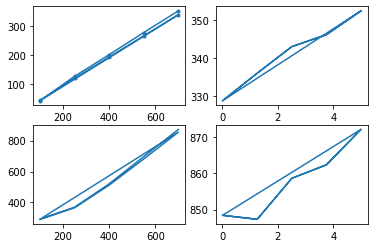

In [20]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(df_cmax.pvalue, df_cmax.output_gpp, marker='.')
axes[1,0].plot(df_cmax.pvalue, df_cmax.output_vegc)

axes[0,1].plot(df_rhq10.pvalue, df_rhq10.output_gpp)
axes[1,1].plot(df_rhq10.pvalue, df_rhq10.output_vegc)

#axes[0].plot(df.pvalue[1:], df.output_gpp[1:])
#axes[0].plot(df.pvalue[0], df.output_gpp[0], marker='^', color='red')
#axes[0].plot(df.pvalue[1:], df.output_vegc[1:])

#axes[1].plot(df.pvalue[1:], df.output_vegc[1:])
#axes[1].plot(df.pvalue[0], df.output_vegc[0], marker='^', color='red')

#df.plot('pvalue','output_gpp', 'output_vegc')
#df.plot('pvalue','output_vegc')

In [18]:
gpp_sens_df = pd.DataFrame(dict(pvalue=df.pvalue[1:], sensitivity=abs(df.output_gpp[0] - df.output_gpp[1:])/abs(df.output_gpp[0])))
vegc_sens_df = pd.DataFrame(dict(pvalue=df.pvalue[1:], sensitivity=abs(df.output_vegc[0] - df.output_vegc[1:])/abs(df.output_vegc[0])))

axes = gpp_sens_df.plot('pvalue', 'sensitivity', kind='line', ylabel='% error from default')
axes = vegc_sens_df.plot('pvalue', 'sensitivity', kind='line', ylabel='% error from default')

NameError: name 'df' is not defined